# Continuous Evaluation

In [1]:
# change these to try this notebook out
BUCKET = 'munn-sandbox'
PROJECT = 'munn-sandbox'
REGION = 'us-central1'

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = '2.1'

In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.1


In [4]:
%%bash
gsutil ls gs://$BUCKET/txtcls/data/

gs://munn-sandbox/txtcls/data/titles_full.csv
gs://munn-sandbox/txtcls/data/titles_sample.csv


In [5]:
!gsutil cp gs://$BUCKET/txtcls/data/titles_full.csv .

Copying gs://munn-sandbox/txtcls/data/titles_full.csv...
- [1 files][  5.4 MiB/  5.4 MiB]                                                
Operation completed over 1 objects/5.4 MiB.                                      


In [6]:
import pandas as pd
from tensorflow.keras.utils import to_categorical

DATASET_NAME = "titles_full.csv"
COLUMNS = ['title', 'source']

titles_df = pd.read_csv(DATASET_NAME, header=None, names=COLUMNS)
titles_df.head()

,title,source
0,led inventor and employer settle for $8.1m 2005,nytimes
1,yc-backed photo-sharing service picplum loses ...,techcrunch
2,as facebook turns 10 zuckerberg wants to chan...,nytimes
3,6 big healthtech ideas that will change medici...,techcrunch
4,building the prince of persia sources to creat...,github


In [7]:
CLASSES = {
    'github': 0,
    'nytimes': 1,
    'techcrunch': 2
}
N_CLASSES = len(CLASSES)

In [8]:
def encode_labels(sources):
    classes = [CLASSES[source] for source in sources]
    one_hots = to_categorical(classes, num_classes=N_CLASSES)
    return one_hots

In [9]:
encode_labels(titles_df.source[:4])

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [10]:
N_TRAIN = int(len(titles_df) * 0.95)

titles_train, sources_train = (
    titles_df.title[:N_TRAIN], titles_df.source[:N_TRAIN])

titles_valid, sources_valid = (
    titles_df.title[N_TRAIN:], titles_df.source[N_TRAIN:])

In [11]:
X_train, Y_train = titles_train.values, encode_labels(sources_train)
X_valid, Y_valid = titles_valid.values, encode_labels(sources_valid)

In [12]:
X_train[:3]

array(['led inventor and employer settle for $8.1m  2005 ',
       'yc-backed photo-sharing service picplum loses one co-founder',
       'as facebook turns 10  zuckerberg wants to change how tech industry works'],
      dtype=object)

## Swivel Model

Then we will try a word embedding obtained using [Swivel](https://arxiv.org/abs/1602.02215), an algorithm that essentially factorizes word co-occurrence matrices to create the words embeddings. 
TF-Hub hosts the pretrained [gnews-swivel-20dim-with-oov](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1) 20-dimensional Swivel module.

In [13]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow_hub import KerasLayer
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model

%matplotlib inline

In [14]:
print(tf.__version__)

2.1.1


In [15]:
SWIVEL = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
swivel_module = KerasLayer(
    SWIVEL, output_shape=[20], input_shape=[], dtype=tf.string, trainable=True)

In [16]:
MODEL_DIR = "./text_model"

In [17]:
def txt_source(x):
    labels = tf.constant(['github', 'techcrunch', 'nytimes'], dtype=tf.string)
    indices = tf.argmax(x, axis=1)
    #return tf.gather(params=labels, indices=indices)
    return tf.cast(tf.argmax(x, axis=1), tf.float32)


def build_model(hub_module, name):
    inputs = Input(shape=[], dtype=tf.string, name="text")
    module = hub_module(inputs)
    h1 = Dense(16, activation='relu', name="h1")(module)
    outputs = Dense(N_CLASSES, activation='softmax', name='outputs')(h1)
    score = Lambda(lambda x: tf.reduce_max(x, axis=1), name="confidence")(outputs)
    pred_label = Lambda(lambda x: txt_source(x), name="source")(outputs)
    
    model = Model(inputs=inputs, outputs=[outputs])
    evaluation_head = Model(inputs=inputs, outputs=[pred_label, score])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    evaluation_head.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
    )
    return model, evaluation_head

In [18]:
def train_and_evaluate(train_data, val_data, model, batch_size=5000):
    X_train, Y_train = train_data

    tf.random.set_seed(33)

    model_dir = os.path.join(MODEL_DIR, model.name)
    if tf.io.gfile.exists(model_dir):
        tf.io.gfile.rmtree(model_dir)

    history = model.fit(
        X_train, Y_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=val_data,
        callbacks=[EarlyStopping(), TensorBoard(model_dir)],
    )
    return history

In [19]:
swivel_model = build_model(swivel_module, name='swivel')

In [20]:
swivel_model[1].summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        (None, 20)           389380      text[0][0]                       
__________________________________________________________________________________________________
h1 (Dense)                      (None, 16)           336         keras_layer[0][0]                
__________________________________________________________________________________________________
outputs (Dense)                 (None, 3)            51          h1[0][0]                         
____________________________________________________________________________________________

In [21]:
data = (X_train, Y_train)
val_data = (X_valid, Y_valid)

For training we'll call `train_and_evaluate` on `swivel_model[0]`.

In [22]:
swivel_history = train_and_evaluate(data, val_data, swivel_model[0])

Train on 91392 samples, validate on 4811 samples
Epoch 1/100
91392/91392 [==============================] - 4s 44us/sample - loss: 1.0678 - accuracy: 0.4473 - val_loss: 1.0295 - val_accuracy: 0.4885
Epoch 2/100
91392/91392 [==============================] - 1s 7us/sample - loss: 0.9991 - accuracy: 0.5061 - val_loss: 0.9751 - val_accuracy: 0.5290
Epoch 3/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.9445 - accuracy: 0.5495 - val_loss: 0.9252 - val_accuracy: 0.5697
Epoch 4/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.8932 - accuracy: 0.5864 - val_loss: 0.8753 - val_accuracy: 0.6040
Epoch 5/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.8417 - accuracy: 0.6200 - val_loss: 0.8249 - val_accuracy: 0.6373
Epoch 6/100
91392/91392 [==============================] - 1s 6us/sample - loss: 0.7902 - accuracy: 0.6497 - val_loss: 0.7752 - val_accuracy: 0.6626
Epoch 7/100
91392/91392 [==============================]

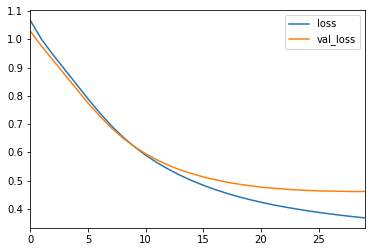

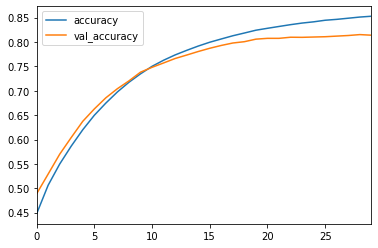

In [23]:
history = swivel_history
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()

Calling predicition from model head produces output from final dense layer. This is what isused to compute categorical cross-entropy when training. 

In [24]:
swivel_model[0].predict(x=["YouTube introduces Video Chapters to make it easier to navigate longer videos"])

array([[0.7106543 , 0.08733202, 0.20201369]], dtype=float32)

Calling prediction from the evaluation_head provides the output required from CAIP Continuous Evaluation.

In [25]:
swivel_model[1].predict(x=["YouTube introduces Video Chapters to make it easier to navigate longer videos"])

[array([0.], dtype=float32), array([0.7106543], dtype=float32)]

In [26]:
tf.saved_model.save(swivel_model[1], './swivel_model/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./swivel_model/assets


INFO:tensorflow:Assets written to: ./swivel_model/assets


In [27]:
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir ./swivel_model/
!find ./swivel_model/

2020-06-05 15:25:11.290139: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2020-06-05 15:25:11.291887: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
The given SavedModel SignatureDef contains the following input(s):
  inputs['text'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_text:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['confidence'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: StatefulPartitionedCall_2:0
  outputs['source'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: StatefulPartitionedCall_2:1
Method name is: tensorflow/serving/predict
./swivel_model/
./swivel_model/saved_model.pb
./swivel_model/variables
./swivel_model/variables/variables.data-00000-of-00002
./swivel_model/variables/variables.index
./swivel_model/variables

## Deploy model

In [180]:
%%bash
MODEL_NAME="txtcls"
MODEL_VERSION="swivel_eval"
MODEL_LOCATION="./swivel_model/"
BUCKET="munn-sandbox"

gcloud ai-platform versions create ${MODEL_VERSION} \
--model ${MODEL_NAME} \
--origin ${MODEL_LOCATION} \
--staging-bucket gs://${BUCKET} \
--runtime-version=2.1

Creating version (this might take a few minutes)......
......................................................................................................................................................................................................................done.


## Set up the Evaluation job on CAIP

Go to Google Cloud Platform to see the model version you've deployed. And set up an evaluation job.

In [200]:
# some stuff here about setting up Eval jobs
# look at the BQ table you created, nothing is there

In [ ]:
%%bigquery
SELECT * FROM `munn-sandbox.txtcls_eval.swivel_eval_job`

## Send prediction requests to your model

We'll create a .json file with multiple titles for prediction

| title  | source  |
|---|---|
| YouTube introduces Video Chapters to make it easier to navigate longer videos  |  techcrunch |
| A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison | nytimes |
| A native Mac app wrapper for WhatsApp Web | github |

In [215]:
%%writefile input.json
{"text": "YouTube introduces Video Chapters to make it easier to navigate longer videos"}

Overwriting input.json


In [216]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel_eval

CONFIDENCE  SOURCE
0.862347    2.0


In [217]:
%%writefile input.json
{"text": "A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison"}

Overwriting input.json


In [218]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel_eval

CONFIDENCE  SOURCE
0.913901    0.0


In [219]:
%%writefile input.json
{"text": "A native Mac app wrapper for WhatsApp Web"}

Overwriting input.json


In [220]:
!gcloud ai-platform predict \
  --model txtcls \
  --json-instances input.json \
  --version swivel_eval

CONFIDENCE  SOURCE
0.568684    0.0


In [221]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [223]:
%%bigquery
SELECT * FROM `munn-sandbox.txtcls_eval.swivel_eval_job`

,model,model_version,time,raw_data,raw_prediction,groundtruth
0,txtcls,swivel_eval,2020-06-01 16:23:02+00:00,"{""instances"": [{""text"": ""A native Mac app wrap...","{""predictions"": [{""confidence"": 0.568684399127...",None
1,txtcls,swivel_eval,2020-06-01 16:22:59+00:00,"{""instances"": [{""text"": ""A Filmmaker Put Away ...","{""predictions"": [{""confidence"": 0.913900554180...",None
2,txtcls,swivel_eval,2020-06-01 16:22:56+00:00,"{""instances"": [{""text"": ""YouTube introduces Vi...","{""predictions"": [{""confidence"": 0.862346708774...",None


## Provide the ground truth for the raw prediction input

In [46]:
%%bigquery
UPDATE `txtcls_eval.swivel_eval_job`
SET 
    groundtruth = '1'
WHERE
    raw_data = '{"instances": [{"text": "A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison"}]}';

""


In [29]:
%%bigquery
UPDATE `txtcls_eval.swivel_eval_job`
SET 
    groundtruth = '2'
WHERE
    raw_data = '{"instances": [{"text": "A Filmmaker Put Away for Tax Fraud Takes Us Inside a British Prison"}]}';

""


In [30]:
%%bigquery
UPDATE `txtcls_eval.swivel_eval_job`
SET 
    groundtruth = '0'
WHERE
    raw_data = '{"instances": [{"text": "A native Mac app wrapper for WhatsApp Web"}]}';

""


In [31]:
%%bigquery
SELECT * FROM `munn-sandbox.txtcls_eval.swivel_eval_job`

,model,model_version,time,raw_data,raw_prediction,groundtruth
0,txtcls,swivel_eval,2020-06-01 16:22:56+00:00,"{""instances"": [{""text"": ""YouTube introduces Vi...","{""predictions"": [{""confidence"": 0.862346708774...",2
1,txtcls,swivel_eval,2020-06-01 16:22:59+00:00,"{""instances"": [{""text"": ""A Filmmaker Put Away ...","{""predictions"": [{""confidence"": 0.913900554180...",2
2,txtcls,swivel_eval,2020-06-01 16:23:02+00:00,"{""instances"": [{""text"": ""A native Mac app wrap...","{""predictions"": [{""confidence"": 0.568684399127...",0


## Compute evaluation metrics

Using regex we can extract the model predictions

In [41]:
%%bigquery
SELECT
  model,
  model_version,
  time,
  REGEXP_EXTRACT(raw_data, r'.*"text": "(.*)"') AS text,
  REGEXP_EXTRACT(raw_prediction, r'.*"source": (\d+)\.0') AS prediction,
  REGEXP_EXTRACT(raw_prediction, r'.*"confidence": (0.\d{2}).*') AS confidence,
  groundtruth,
FROM
  `txtcls_eval.swivel_eval_job`

,model,model_version,time,text,prediction,confidence,groundtruth
0,txtcls,swivel_eval,2020-06-01 16:22:56+00:00,YouTube introduces Video Chapters to make it e...,2,0.86,2
1,txtcls,swivel_eval,2020-06-01 16:22:59+00:00,A Filmmaker Put Away for Tax Fraud Takes Us In...,0,0.91,2
2,txtcls,swivel_eval,2020-06-01 16:23:02+00:00,A native Mac app wrapper for WhatsApp Web,0,0.56,0


In [42]:
%%bigquery
WITH
  comparison_table AS (
  SELECT
    groundtruth,
    REGEXP_EXTRACT(raw_prediction, r'.*source": (\d+)\.0') AS prediction,
  FROM
    `munn-sandbox.txtcls_eval.swivel_eval_job`),
  correct_table AS (
  SELECT
    CASE
      WHEN groundtruth = prediction THEN 1
    ELSE
    0
  END
    AS correct_pred
  FROM
    comparison_table)
SELECT
  SUM(correct_pred)/COUNT(*) AS accuracy
FROM
  correct_table

,accuracy
0,0.666667
